In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import category_encoders as ce
from kneed import KneeLocator, DataGenerator

import matplotlib.pyplot as plt

#Graphic library plotly
import plotly.graph_objects as go

# Read in data, add header row and display first 5 rows
users = pd.read_csv('data_student.xls')
users.head(5)

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,very_low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low


# Identify Anomalies/ Missing Data

In [2]:
print('The shape of our users dataset is:', users.shape)

The shape of our users dataset is: (258, 6)


**To identify anomalies, we can quickly compute summary statistics.**

In [3]:
# Descriptive statistics for each column
users.describe()

,STG,SCG,STR,LPR,PEG
count,258.000000,258.000000,258.000000,258.000000,258.000000
mean,0.371147,0.355674,0.468004,0.432713,0.458539
std,0.210271,0.211962,0.245940,0.248108,0.255211
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.240750,0.210000,0.291250,0.250000,0.250000
50%,0.327000,0.302500,0.490000,0.330000,0.500000
75%,0.495000,0.497500,0.690000,0.647500,0.660000
max,0.990000,0.900000,0.950000,0.990000,0.930000


In [4]:
users.isna().sum()

STG    0
SCG    0
STR    0
LPR    0
PEG    0
UNS    0
dtype: int64

In [5]:
(users==0).sum()

STG    2
SCG    2
STR    1
LPR    1
PEG    2
UNS    0
dtype: int64

Get columns 'UNS' (user Knowledge) unique values

In [6]:
users.UNS.unique()

array(['very_low', 'High', 'Low', 'Middle'], dtype=object)

In [7]:
# create object of Ordinalencoding
encoder= ce.OrdinalEncoder(cols=['UNS'],return_df=True,
                           mapping=[{'col':'UNS',
'mapping':{'very_low':1,'Low':2,'Middle':3,'High':4}}])

#fit and transform train data 
users_transformed = encoder.fit_transform(users)


users_data = users_transformed.drop(['SCG', 'STR', 'LPR', 'UNS'], axis=1)
users_data.head(5)

,STG,PEG
0,0.00,0.00
1,0.08,0.90
2,0.06,0.33
3,0.10,0.30
4,0.08,0.24


## Running K-Means with a range of k

We can easily run K-Means for a range of clusters using a for loop and collecting the distortions into a list.

In [8]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(users_data)
    distortions.append(kmeanModel.inertia_)

## Plotting the distortions of K-Means

In [9]:
fig = go.Figure(data=go.Scatter(
    x = list(K),
    y = distortions,
))

fig.update_xaxes(title_text="k")
fig.update_yaxes(title_text="Distortion")

fig.update_layout(
    title={
        'text': "The Elbow Method showing the optimal k",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

We can observe that the “elbow” is the number 3 which is optimal for this case.
We can also check it using a Python package, kneed wich identify the elbow point programmatically:

In [10]:
kl = KneeLocator(range(1, 10), distortions, curve="convex", direction="decreasing")
kl.elbow

3

Now we can run a K-Means using as n_clusters the number 4.

In [11]:
kmeanModel = KMeans(n_clusters=4, init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan')
users_data['k_means']=kmeanModel.fit_predict(users_data)
print(users_data['k_means'])

0      2
1      3
2      2
3      2
4      2
      ..
253    0
254    0
255    0
256    1
257    0
Name: k_means, Length: 258, dtype: int32


In [12]:
kmeanModel.cluster_centers_

array([[0.71810811, 0.65594595],
       [0.51728889, 0.24488889],
       [0.21289744, 0.20478205],
       [0.299     , 0.68408163]])

Text(0.5, 1.0, 'K_Means')

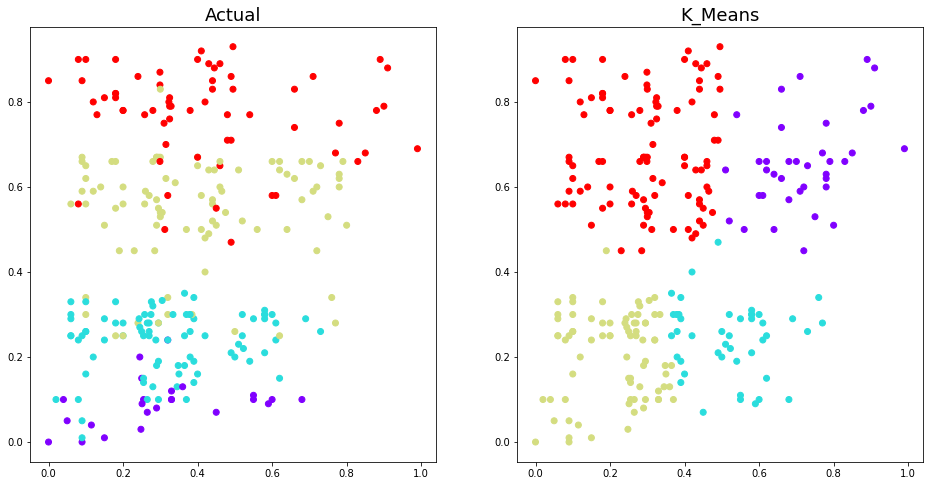

In [13]:
# plt.scatter(users[:, 0], users[:, 1], c=users_transformed['k_means'], cmap='rainbow')

# plt.scatter(users['PEG'], users['SCG'], c=users_transformed['k_means'], cmap='rainbow')

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(users['STG'], users['PEG'], c=users_transformed['UNS'], cmap='rainbow')
axes[1].scatter(users['STG'], users['PEG'], c=kmeanModel.labels_, cmap='rainbow')
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('K_Means', fontsize=18)

In [14]:
# x and y given as DataFrame columns
import plotly.express as px

fig_actual = px.scatter(users, x=users['STG'], y=users['PEG'], color=users['UNS'],
                color_discrete_sequence=["red", "green", "blue", "goldenrod"])

fig_K_Means = px.scatter(users, x=users['STG'], y=users['PEG'], color=kmeanModel.labels_,
                color_discrete_sequence=["red", "green", "blue", "goldenrod"])

fig_K_Means.show()

In [15]:
import plotly.express as px
from plotly.subplots import make_subplots

fig_actual = px.scatter(users, x=users['STG'], y=users['PEG'], color=users['UNS'],
                color_discrete_sequence=["red", "green", "blue", "goldenrod"])

fig_K_Means = px.scatter(users, x=users['STG'], y=users['PEG'], color=kmeanModel.labels_,
                    color_discrete_map={
                        "0": "red",
                        "1": "green",
                        "2": "blue",
                        "3": "goldenrod"
                    }
            )


trace1_0 = fig_actual['data'][0]
trace1_1 = fig_actual['data'][1]
trace1_2 = fig_actual['data'][2]
trace1_3 = fig_actual['data'][3]

trace2 = fig_K_Means['data'][0]

fig = make_subplots(rows=1, cols=2, shared_xaxes=False, shared_yaxes=False,
                   subplot_titles=("Actual", "K_Means"))

fig.add_trace(trace1_0, row=1, col=1)
fig.add_trace(trace1_1, row=1, col=1)
fig.add_trace(trace1_2, row=1, col=1)
fig.add_trace(trace1_3, row=1, col=1)

fig.add_trace(trace2, row=1, col=2)

# Update xaxis properties
fig.update_xaxes(title_text="STG", row=1, col=1)
fig.update_xaxes(title_text="STG", row=1, col=2)


# Update yaxis properties
fig.update_yaxes(title_text="PEG", row=1, col=1)
fig.update_yaxes(title_text="PEG", row=1, col=2)

fig.update_layout(coloraxis_showscale=False)

fig.show()